In [1]:
import json
import os
import csv
import rdflib
from rdflib import ConjunctiveGraph, Graph, URIRef, Literal, Namespace
from rdflib.namespace import SKOS, DCTERMS, DCMITYPE, RDF, RDFS, XSD, PROV, split_uri

from openai import OpenAI
from google import genai
from google.genai import types
from langchain.chains import GraphSparqlQAChain
from langchain_community.graphs import RdfGraph
from langchain_openai import ChatOpenAI

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from uk2us import uk_us

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx

In [2]:
# Opening config file, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']

In [3]:
with open("in_ontovocabs/classes.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(reader)  # Read all rows into a list

    classes = [row['class'] for row in rows]
    clabel = [row['label'] for row in rows]

In [4]:
with open("in_ontovocabs/properties.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(reader)  # Read all rows into a list

    prop = [row['prop'] for row in rows]
    plabel = [row['label'] for row in rows]

In [5]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

In [6]:
def print_rdf(rdf):
    g = rdflib.Graph()
    g.parse(data=rdf, format="turtle")

    for s, p, o in g:
        print(s, p, o)

In [7]:
# Namespaces
she = Namespace("https://soilwise-he.github.io/soil-health#")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
agrontology = Namespace("http://aims.fao.org/aos/agrontology#")
sio = Namespace("http://semanticscience.org/resource/")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")
glosis_sp = Namespace("http://w3id.org/glosis/model/siteplot/")
eli = Namespace("http://data.europa.eu/eli/ontology#")
qudt = Namespace("http://qudt.org/schema/qudt/")
unit = Namespace("http://qudt.org/vocab/unit/")
quantitykind = Namespace("http://qudt.org/vocab/quantitykind/")
country = Namespace("http://publications.europa.eu/resource/authority/country/")
iso11074 = Namespace("https://data.geoscience.earth/ncl/ISO11074/")
schema = Namespace("https://schema.org/")
ro = Namespace("http://purl.obolibrary.org/obo/RO_")
t4fs = Namespace("http://purl.obolibrary.org/obo/T4FS_")

In [8]:
with open('report/soil_report.json', 'r') as file:
    report = json.load(file)

print(report[541]['text'])

The corresponding maps for the test implementation of the indicators proposed in this report are available on request from the EEA.


In [9]:
with open('report/references.json', 'r') as file:
    references = json.load(file)

print(references[632]['text'])

Zöttl, H. W. and Mies, E., 1983, 'Nährelementversorgung und Schadstoffbelastung von Fichtenökosystemen im Südschwarzwald unter Immissionseinfluß', Mitteilungen der Deutschen Botanischen Gesellschaft 38, pp. 429-434.


### A simple example of converting text to RDF triples

In [27]:
# Load the JSON dataset
with open('benchmarks/text_RDF_gs.json', 'r') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [25]:
# Corresponding ground-truth RDF statements
print(dataset[15]['rdf_graph_turtle'])

@prefix ro: <http://purl.obolibrary.org/obo/RO_> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:SoilEcologicalDegradation a skos:Concept ;
    ro:0002212 she:EcosystemFunctions,
        she:HydrologicalCycle,
        she:NetBiomeProductivity ;
    skos:definition "Soil ecological degradation reflects a combination of the other three types of degradation." ;
    skos:prefLabel "soil ecological degradation" .

she:EcosystemFunctions a skos:Concept ;
    skos:narrower she:ElementCycling,
        she:WaterInfiltration,
        she:WaterPurification ;
    skos:prefLabel "ecosystem functions" .

she:ElementCycling a skos:Concept ;
    skos:prefLabel "element cycling" .

she:HydrologicalCycle a skos:Concept ;
    skos:prefLabel "hydrological cycle" .

she:NetBiomeProductivity a skos:Concept ;
    skos:prefLabel "net biome productivity" .

she:WaterInfiltration a skos:Concept ;
    skos:prefLabel "water infiltration" .


In [26]:
# Raw texts from the report
print(dataset[15]['text'])

Soil ecological degradation: although a clear characterisation of soil ecological condition, and what is to be considered a reference, is largely lacking, ecological degradation reflects a combination of the other three types of degradation. This leads to a disruption in ecosystem functions, such as element cycling and water infiltration and purification, perturbations in the hydrological cycle and a decline in net biome productivity.


In [21]:
rdf = """@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix ro: <http://purl.obolibrary.org/obo/RO_> .

she:SoilEcologicalDegradation a skos:Concept ;
    skos:definition "Soil ecological degradation reflects a combination of the other three types of degradation." ;
    ro:0002212 she:HydrologicalCycle, she:EcosystemFunctions, she:NetBiomeProductivity ;
    skos:prefLabel "soil ecological degradation" .

she:HydrologicalCycle a skos:Concept ;
    skos:prefLabel "hydrological cycle" .

she:WaterPurification a skos:Concept ;
    skos:prefLabel "water purification" .

she:WaterInfiltration a skos:Concept ;
    skos:prefLabel "water infiltration" .

she:EcosystemFunctions a skos:Concept ;
    skos:narrower she:ElementCycling, she:WaterInfiltration, she:WaterPurification ;
    skos:prefLabel "ecosystem functions" .

she:ElementCycling a skos:Concept ;
    skos:prefLabel "element cycling" .

she:NetBiomeProductivity a skos:Concept ;
    skos:prefLabel "net biome productivity" ."""

In [22]:
g = load_graph(rdf)

In [23]:
print(json.dumps(g.serialize(format="turtle")))

"@prefix ro: <http://purl.obolibrary.org/obo/RO_> .\n@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:SoilEcologicalDegradation a skos:Concept ;\n    ro:0002212 she:EcosystemFunctions,\n        she:HydrologicalCycle,\n        she:NetBiomeProductivity ;\n    skos:definition \"Soil ecological degradation reflects a combination of the other three types of degradation.\" ;\n    skos:prefLabel \"soil ecological degradation\" .\n\nshe:EcosystemFunctions a skos:Concept ;\n    skos:narrower she:ElementCycling,\n        she:WaterInfiltration,\n        she:WaterPurification ;\n    skos:prefLabel \"ecosystem functions\" .\n\nshe:ElementCycling a skos:Concept ;\n    skos:prefLabel \"element cycling\" .\n\nshe:HydrologicalCycle a skos:Concept ;\n    skos:prefLabel \"hydrological cycle\" .\n\nshe:NetBiomeProductivity a skos:Concept ;\n    skos:prefLabel \"net biome productivity\" .\n\nshe:WaterInfiltration a skos:Concept ;\n  


(process:21064): Pango-WARNING **: 16:50:37.673: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:21064): Pango-WARNING **: 16:50:37.673: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:21064): Pango-WARNING **: 16:50:37.683: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



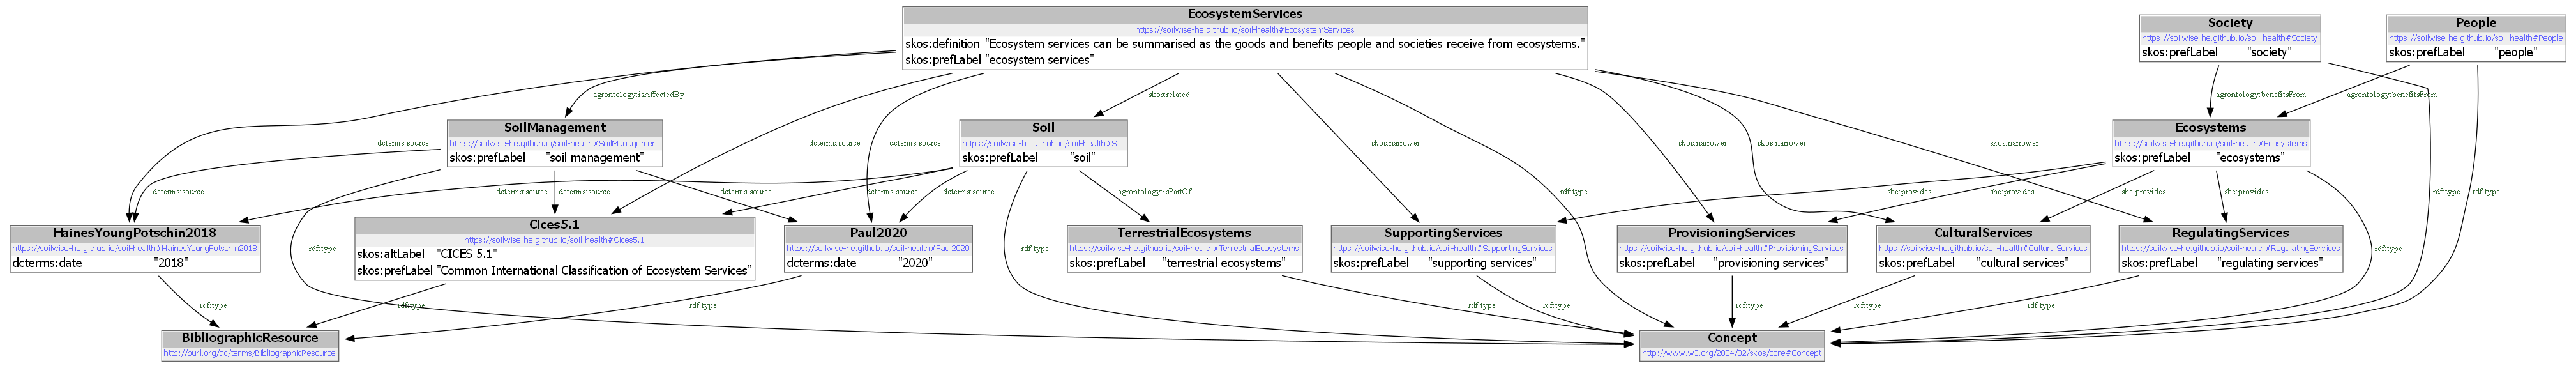

In [21]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

### Convert text to RDF triples using LLMs: zero-shot prompting

In [16]:
# System prompt for zero-shot learning
system_prompt_text = """You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with the human-readable name found in the text for every concept and entity. If an entity is not a concept, search for a class from an existing ontology. URIs should be names or human-readable identifiers derived from the text. Use 'she: <https://soilwise-he.github.io/soil-health#>' as prefix. Split words in URIs by capitalizing initial letters.

Relationships represent connections between entities or concepts. Attempt to extract as many relations as you can. Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. Emphasize generality to enhance the universality and longevity of the knowledge graph.

Maintain entity consistency when extracting entities. If an entity is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier for that entity throughout the knowledge graph.

Do not retain the given text as objects, except in the following case: if the text is defining entities or concepts, include the full definition as an object and use 'skos:definition' as the predicate. Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

Identify any references or citations that appear in the text. Use Dublin Core ('dcterms') to label references. Represent each reference as a 'dcterms:BibliographicResource'. Use 'dcterms:source' to indicate which information in the text references this literature. When an extracted piece of information is supported by a reference, link it to the corresponding 'dcterms:BibliographicResource' using 'dcterms:source'.

You will receive one paragraph at a time from the soil health report. Focus on extracting information solely from the provided paragraph without assuming context from previous paragraphs. Adhere to the rules strictly. Non-compliance will result in termination."""

In [18]:
prompt_0 = f"""Please help me convert this text to an RDF knowledge graph:
'{dataset[15]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!"""

In [19]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_text},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:SoilEcologicalDegradation a skos:Concept ;
    skos:prefLabel "Soil ecological degradation" ;
    skos:definition "Soil ecological degradation: although a clear characterisation of soil ecological condition, and what is to be considered a reference, is largely lacking, ecological degradation reflects a combination of the other three types of degradation." .

she:EcosystemFunctions a skos:Concept ;
    skos:prefLabel "Ecosystem functions" .

she:ElementCycling a skos:Concept ;
    skos:prefLabel "Element cycling" .

she:WaterInfiltration a skos:Concept ;
    skos:prefLabel "Water infiltration" .

she:WaterPurification a skos:Concept ;
    skos:prefLabel "Water purification" .

she:HydrologicalCycle a skos:Concept ;
    skos:prefLabel "Hydrological cycle" .

she:NetBiomeProductivity a skos:Concept ;
    skos:prefLabel "Net biome productivity" .

she:SoilEcolog

In [20]:
client = genai.Client(api_key=config['gemini_api_key'])

response = client.models.generate_content(
    model="gemini-2.0-pro-exp-02-05",
    config=types.GenerateContentConfig(
        system_instruction=system_prompt_text),
    contents=[prompt_0]
)

print(response.text)

```turtle
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:SoilChemicalDegradation a skos:Concept ;
  skos:prefLabel "Soil chemical degradation" ;
  skos:definition "Soil chemical degradation is characterised by changes in soil processes, including nutrient depletion, acidification, salinisation and contamination, which in turn leads to a reduced cation exchange capacity, increased aluminium or manganese toxicities, calcium or magnesium deficiencies, and leaching of nitrate nitrogen or other essential plant nutrients." .

she:SoilProcesses a skos:Concept ;
  skos:prefLabel "soil processes" .

she:NutrientDepletion a skos:Concept ;
  skos:prefLabel "nutrient depletion" .

she:Acidification a skos:Concept ;
  skos:prefLabel "acidification" .

she:Salinisation a skos:Concept ;
  skos:prefLabel "salinisat

In [ ]:
client = OpenAI(api_key=config['deepseek_api_key'], base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt_text},
        {"role": "user", "content": prompt_0},
    ],
    stream=False
)

print(response.choices[0].message.content)

In [21]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```turtle', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('```', '')

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

https://soilwise-he.github.io/soil-health#SoilBiologicalDegradation http://www.w3.org/2004/02/skos/core#definition Refers to reduced soil biological activity, which can be accompanied by a loss of soil biodiversity. This leads to lower levels of mineralisation and respiration and an accumulation of incompletely decomposed dead organic matter (necromass). Nutrient availability is reduced, and organic matter accumulates in forest topsoils. In peat soils, degradation (caused by drainage) leads to SOC losses.
https://soilwise-he.github.io/soil-health#SoilEcologicalDegradation http://www.w3.org/2004/02/skos/core#definition Although a clear characterisation of soil ecological condition, and what is to be considered a reference, is largely lacking, ecological degradation reflects a combination of the other three types of degradation. This leads to a disruption in ecosystem functions, such as element cycling and water infiltration and purification, perturbations in the hydrological cycle and a

#### Validate Turtle syntax

In [97]:
system_prompt_ttl_checker = """**Revised System Prompt**

**Task Description**:
You are an **RDF Turtle syntax checker and reviser**. Your task is to:

1. **Receive RDF triples** serialized in Turtle format, which contain syntax errors.
2. Be aware that the input may use the custom prefix: `she: <https://soilwise-he.github.io/soil-health#> .`
3. **Analyze the input** and correct any syntactical issues while preserving the original semantic meaning as much as possible.
4. **Describe the error pattern**: Provide a concise and precise description of the syntax error, similar to the brief error messages seen in code debugging tools.
5. **Fix the error**: Correct the syntax error to produce valid RDF Turtle output.

**Guidelines**:

- Ensure the corrected RDF Turtle is syntactically correct and can be directly parsed by the Python library **"rdflib"**.
- Do not include any additional commentary, code block markers, or language identifiers (e.g., ```turtle) in your output—only the corrected RDF triples."""

In [98]:
prompt_ttl = f"""Please check and correct the following RDF triples:
{completion.choices[0].message.content}"""

In [99]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_ttl_checker},
        {
            "role": "user",
            "content": prompt_ttl
        }
    ],
    response_format={ 
        "type": "json_schema", 
        "json_schema": {
            "name": "rdf_turtle_checker_reviser",
            "schema": {
                "type": "object",
                "properties": {
                    "turtle_error_pattern": {
                        "type": "string",
                        "description": "A brief and clear description of the syntax error identified."
                        },
                    "output_rdf": {
                        "type": "string",
                        "description": "The corrected RDF Turtle output without syntax errors."
                        }
                    },
                "required": [
                    "turtle_error_pattern",
                    "output_rdf"
                ],
                "additionalProperties": False
            },
            "strict": True
        }
    }
)

print(completion.choices[0].message.content)

{"turtle_error_pattern":"The 'dcterms:source' property expects an IRI but received a plain literal in 'she:EUSoilThematicStrategy2006'.","output_rdf":"@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n@prefix dcterms: <http://purl.org/dc/terms/> .\n\nshe:CounteractingSoilThreats a skos:Concept ;\n    skos:prefLabel \"Counteracting soil threats\" ;\n    skos:definition \"Represents the main structural element of soil protection according to the 2006 EU soil thematic strategy.\" ;\n    dcterms:source she:EUSoilThematicStrategy2006 .\n\nshe:EUSoilThematicStrategy2006 a dcterms:BibliographicResource ;\n    dcterms:title \"2006 EU soil thematic strategy\" .\n\nshe:WorldSoilResourcesReport2015 a dcterms:BibliographicResource ;\n    dcterms:title \"Status of the world's soil resources report (FAO and ITPS, 2015)\" .\n\nshe:SoilThreats a skos:Concept ;\n    skos:prefLabel \"Soil threats\" ;\n    skos:definition \"Processes that

In [100]:
print(json.loads(completion.choices[0].message.content)["turtle_error_pattern"])

The 'dcterms:source' property expects an IRI but received a plain literal in 'she:EUSoilThematicStrategy2006'.


In [101]:
print(json.loads(completion.choices[0].message.content)["output_rdf"])

@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:CounteractingSoilThreats a skos:Concept ;
    skos:prefLabel "Counteracting soil threats" ;
    skos:definition "Represents the main structural element of soil protection according to the 2006 EU soil thematic strategy." ;
    dcterms:source she:EUSoilThematicStrategy2006 .

she:EUSoilThematicStrategy2006 a dcterms:BibliographicResource ;
    dcterms:title "2006 EU soil thematic strategy" .

she:WorldSoilResourcesReport2015 a dcterms:BibliographicResource ;
    dcterms:title "Status of the world's soil resources report (FAO and ITPS, 2015)" .

she:SoilThreats a skos:Concept ;
    skos:prefLabel "Soil threats" ;
    skos:definition "Processes that damage soil and its functional properties. This damage then reduces the soil's capacity to provide ecosystem services." ;
    dcterms:source she:WorldSoilResourcesReport2015, she

In [102]:
print_rdf(json.loads(completion.choices[0].message.content)["output_rdf"])
g_0 = load_graph(json.loads(completion.choices[0].message.content)["output_rdf"])

https://soilwise-he.github.io/soil-health#EUSoilThematicStrategy2006 http://purl.org/dc/terms/title 2006 EU soil thematic strategy
https://soilwise-he.github.io/soil-health#Erosion http://www.w3.org/2004/02/skos/core#prefLabel Erosion
https://soilwise-he.github.io/soil-health#EcosystemServices http://www.w3.org/2004/02/skos/core#prefLabel Ecosystem services
https://soilwise-he.github.io/soil-health#SoilProperties http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
https://soilwise-he.github.io/soil-health#FocalAreasForSensitiveManagement http://www.w3.org/2004/02/skos/core#prefLabel Focal areas for sensitive management
https://soilwise-he.github.io/soil-health#SoilThreats http://purl.org/dc/terms/source https://soilwise-he.github.io/soil-health#WorldSoilResourcesReport2015
https://soilwise-he.github.io/soil-health#CounteractingSoilThreats http://www.w3.org/2004/02/skos/core#definition Represents the main structural element of soil protection acco

#### Literals re-extractor

In [22]:
system_prompt_extractor = """### System Prompt: Text Re-Extractor for RDF Knowledge Graphs

You are a highly specialized algorithm designed to verify and enhance RDF knowledge graphs generated from unstructured soil science text. Your task is to **ensure completeness and sufficiency** in entity and relationship extraction. This process involves analyzing existing RDF triples, identifying unextracted entities and relationships, and incorporating them into an improved RDF knowledge graph.

**Instructions**:

1. **Input**:
   You will be provided with **LLM-generated RDF triples**: An initial RDF knowledge graph in Turtle format.
2. **Goal**:
   Verify whether the text stored in the RDF (e.g., under `skos:definition` or other literal fields) still contains **entities** or **relationships** that have not been sufficiently extracted. If the text mentions relevant soil science concepts or relationships that are missing in the RDF, you must extract them and include them as new triples.
3. **Entity Extraction**:
   
   - **Entities** refer to all concepts, objects, or elements relevant to soil science and soil health.
   - Entities that are recognized as concepts should be labeled using the **SKOS**. Specifically:
     - Use `skos:Concept` to label concepts.
     - Use `skos:prefLabel` to provide a human-readable name for each concept.
   - If the text refers to **composite entities**, ensure all components are separately identified.
4. **Relationship Extraction**:
   
   - Relationships (predicates) must describe general and universal connections between entities.
   - Avoid specific or temporary predicates. Focus on predicates that ensure **clarity, simplicity, and universality**.
5. **Improvement Rules**:
   
   - For each literal string (e.g., `skos:definition` or text objects), perform a **re-extraction pass**:
     - Check if additional entities or relationships can be identified.
     - If so, extract them and integrate them into new RDF triples.
   - If no new information can be extracted, retain the RDF as-is.
6. **Output**:
   Provide the **improved RDF knowledge graph** in Turtle format without any additional commentary, code block markers, or language identifiers (e.g., ```turtle) in your output. Ensure the graph is clean, well-structured, and adheres to the original namespace conventions."""

In [23]:
prompt_extractor = f"""Here is the LLM-generated RDF triples in Turtle format that need to be processed to extract any additional entities and relationships:
{completion.choices[0].message.content}"""

In [24]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_extractor},
        {
            "role": "user",
            "content": prompt_extractor
        }
    ]
)

print(completion.choices[0].message.content)

@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:SoilDegradation a skos:Concept ;
    skos:prefLabel "Soil degradation" ;
    skos:narrower she:SoilPhysicalDegradation, she:SoilChemicalDegradation, she:SoilBiologicalDegradation, she:SoilEcologicalDegradation .

she:SoilPhysicalDegradation a skos:Concept ;
    skos:prefLabel "Soil physical degradation" ;
    skos:definition "A reduction in structural attributes, including pore geometry and continuity, thus aggravating a soil's susceptibility to crusting, compaction, reduced water infiltration, increased surface run-off, wind and water erosion, greater soil temperature fluctuations and an increased propensity for desertification. It also includes soil excavation and soil sealing." ;
    dcterms:source she:Lal2015 .

she:Crusting a skos:Concept ;
    skos:prefLabel "Crusting" .

she:Compaction a skos:Concept ;
    skos:pre

In [53]:
rdf_data_llm_0 = completion.choices[0].message.content

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

https://soilwise-he.github.io/soil-health#Soil https://soilwise-he.github.io/soil-health#composedOf https://soilwise-he.github.io/soil-health#OrganicCompounds
https://soilwise-he.github.io/soil-health#Soil https://soilwise-he.github.io/soil-health#varies https://soilwise-he.github.io/soil-health#Space
https://soilwise-he.github.io/soil-health#Soil https://soilwise-he.github.io/soil-health#provides https://soilwise-he.github.io/soil-health#EcosystemServices
https://soilwise-he.github.io/soil-health#Soil https://soilwise-he.github.io/soil-health#composedOf https://soilwise-he.github.io/soil-health#LivingOrganisms
https://soilwise-he.github.io/soil-health#OrganicCompounds http://www.w3.org/2004/02/skos/core#prefLabel Organic Compounds
https://soilwise-he.github.io/soil-health#LivingOrganisms http://www.w3.org/2004/02/skos/core#prefLabel Living Organisms
https://soilwise-he.github.io/soil-health#Soil http://www.w3.org/2004/02/skos/core#prefLabel Soil
https://soilwise-he.github.io/soil-heal

In [54]:
# Load the valid property list from the CSV file
def load_property_terms(csv_file_path):
    property_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop_uri = row['uri'].strip()
            label = row['label'].strip()
            property_terms.append({
                'uri': prop_uri,
                'label': label
            })
    return property_terms

# Preprocess the term to add spaces between camel case words
def preprocess_term(term):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', term)

# Generate embeddings using OpenAI API
def get_embedding(text):
    preprocessed_text = preprocess_term(text)
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=preprocessed_text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid property terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['uri']] = get_embedding(text_to_embed)
    return embeddings

# Extract the term from the URI, handling both '#' and '/'
def extract_term_from_uri(uri):
    return uri.split("#")[-1] if "#" in uri else uri.split("/")[-1]

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['uri'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Function to check if predicates are in the property list before embedding
def check_predicates_in_property_list(predicates, valid_uris):
    predicates_not_in_list = [pred for pred in predicates if pred not in valid_uris]
    return predicates_not_in_list

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(graph, csv_file_path):
    # Step 1: Load valid property terms
    property_terms = load_property_terms(csv_file_path)
    valid_uris = [term['uri'] for term in property_terms]

    # Step 2: Extract all predicates from the graph
    predicates = set(str(pred) for _, pred, _ in graph)

    # Step 3: Check if there are predicates not in the property list
    predicates_not_in_list = check_predicates_in_property_list(predicates, valid_uris)

    # Step 4: Precompute embeddings for valid property terms if needed
    if predicates_not_in_list:
        valid_term_embeddings = embed_valid_terms(property_terms)
    else:
        valid_term_embeddings = {}
    
    # Step 5: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str in predicates_not_in_list:
            # Extract the term from the URI (handling both '#' and '/')
            predicate_short = extract_term_from_uri(pred_str)
            # Find the closest valid term
            closest_term, similarity = find_closest_term(predicate_short, property_terms, valid_term_embeddings)
            print(predicate_short, extract_term_from_uri(closest_term), similarity)
            if similarity > 0.5:  # Threshold for correction
                # Replace the wrong predicate with the closest valid term
                graph.add((s, rdflib.URIRef(closest_term), o))
                graph.remove((s, pred, o))
    
    return graph

g_0 = check_and_correct_rdf(g_0, 'in_ontovocabs/properties.csv')
print(g_0.serialize(format="turtle"))

composedOf isComposedOf 0.8182982594439617
varies variesIn 0.8404992821885107
composedOf isComposedOf 0.81831226119106
composedOf isComposedOf 0.8182400890769688
bibliographicCitation title 0.3720283949031345
composedOf isComposedOf 0.818204342530063
varies variesIn 0.8404992821885107
composedOf isComposedOf 0.8182573654305512
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:Soil a skos:Concept ;
    ns1:isComposedOf she:Air,
        she:LivingOrganisms,
        she:MineralCompounds,
        she:OrganicCompounds,
        she:Water ;
    dcterms:source she:YoungAndCrawford2004 ;
    skos:definition "The top terrestrial layer of the Earth; composed of a mixture of mineral and organic compounds, water, air and living organisms; one of the most complex biomaterials on earth" ;
    skos:prefLabel "Soil" ;
    she:provides

In [25]:
print(json.dumps(g_0.serialize(format="turtle")))

"@prefix dcterms: <http://purl.org/dc/terms/> .\n@prefix ns1: <http://aims.fao.org/aos/agrontology#> .\n@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:Air a skos:Concept ;\n    ns1:compose she:Soil ;\n    skos:prefLabel \"Air\" .\n\nshe:EcosystemService a skos:Concept ;\n    skos:prefLabel \"Ecosystem Service\" ;\n    she:isProvidedBy she:Soil .\n\nshe:LifeSupportFunction a skos:Concept ;\n    skos:prefLabel \"Life Support Function\" ;\n    she:isProvidedBy she:Soil .\n\nshe:LivingOrganism a skos:Concept ;\n    ns1:compose she:Soil ;\n    skos:prefLabel \"Living Organism\" .\n\nshe:MineralCompound a skos:Concept ;\n    ns1:compose she:Soil ;\n    skos:prefLabel \"Mineral Compound\" .\n\nshe:OrganicCompound a skos:Concept ;\n    ns1:compose she:Soil ;\n    skos:prefLabel \"Organic Compound\" .\n\nshe:Water a skos:Concept ;\n    ns1:compose she:Soil ;\n    skos:prefLabel \"Water\" .\n\nshe:YoungAndCrawford2004 a 

### Prompt engineering

#### Step-by-step prompting

In [32]:
# System prompt for zero-shot learning
system_prompt_step = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
  - For every concept, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers derived from the text. Use `she: <https://soilwise-he.github.io/soil-health#>` as prefix. Split words in URIs by capitalizing initial letters.

## 4. Relations and Predicates
- **Relationships** represent connections between entities or concepts.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs.
- Instead of using specific and momentary predicates, use more general and timeless relationship predicates.
- **Emphasize Generality**: Make sure to use general and timeless relationship predicates to enhance the universality and longevity of the knowledge graph.

## 5. Coreference Resolution
- **Maintain Entity/Concept Consistency**: When extracting entities and concepts, it's vital to ensure consistency.
- If an entity or concept is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier and preferred label for that entity or concept throughout the knowledge graph.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects, except in the following case:
  - **Definitions**: If the text is defining concepts, include the full definition as an object and use `'skos:definition'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

## 7. Quantitative relationship
- Express **quantitative relationships** between entities or concepts, using math ontology, QUDT ontology, or other suitable ontologies.

## 8. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - Do not include `skos:prefLabel` for any references, instead use properties from Dublin Core.
- **Connecting Information to References**:
  - Use `dcterms:source` to indicate which information in the text references this literature.
  - When an extracted piece of information is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 9. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

In [64]:
system_prompt_engi = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, and references from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities relevant to **soil science and soil health**.
- Attempt to extract as many entities as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
  - For every concept, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers found in the text.
- For example, the concept `'soil health'` should have the URI `'she:SoilHealth'` and include `skos:prefLabel 'soil health'`, where the prefix `she: <https://soilwise-he.github.io/soil-health#>`.

## 4. Relations and Predicates
- **Relationships** represent connections between entities.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. **Make sure to use general and timeless relationship predicates.**
- For example, the relationship extracted from the text `'Soil provides multiple functions'` should be that soil `'isSourceOf'` soil functions, rather than that soil `'provides'` soil functions.

## 5. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
- If an entity, such as `'soil functions'`, is mentioned multiple times in the text but is referred to by different forms (e.g., `'soil function'`, `'functions of soil'`), always use the most complete identifier for that entity throughout the knowledge graph. In this example, use `'soil functions'` as the entity label.
- Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects, except in the following case:
  - **Definitions**: If the text is defining concepts, include the full definition as an object and use `'skos:definition'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - For example, a reference like `(Alice and Bob, 2024)` should be represented as: `she:AliceBob2024 a dcterms:BibliographicResource;`. `James et al. (2018)` should be `she:James2018` and `(ABC, 2014a)` should be `she:ABC2014a`.
  - Do not include a `skos:prefLabel` for any reference, use properties from Dublin Core.
- **Connecting Entities to References**:
  - When an extracted entity is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

In [33]:
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[0]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [42]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_step},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:Soil a skos:Concept ;
    skos:prefLabel "soil" ;
    skos:definition "is the top terrestrial layer of the Earth; is composed of a mixture of mineral and organic compounds, water, air and living organisms; is one of the most complex biomaterials on earth (Young and Crawford, 2004); provides multiple functions that support the delivery of ecosystem services, including the life support function; varies naturally in both space and time over a range of scales." ;
    dcterms:source she:YoungCrawford2004 .

she:YoungCrawford2004 a dcterms:BibliographicResource ;
    dcterms:creator "Young", "Crawford" ;
    dcterms:date "2004" .
```


In [303]:
prompt_ttl = f"""Please check and correct the following RDF triples:
{completion.choices[0].message.content}"""

In [304]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_ttl_checker},
        {
            "role": "user",
            "content": prompt_ttl
        }
    ]
)

print(completion.choices[0].message.content)

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:EcosystemServices a skos:Concept ;
    skos:prefLabel "ecosystem services" ;
    skos:definition "Ecosystem services can be summarised as the goods and benefits people and societies receive from ecosystems" .

she:Soil a skos:Concept ;
    skos:prefLabel "soil" .

she:Ecosystems a skos:Concept ;
    skos:prefLabel "ecosystems" .

she:SupportingServices a skos:Concept ;
    skos:prefLabel "supporting services" .

she:RegulatingServices a skos:Concept ;
    skos:prefLabel "regulating services" .

she:ProvisioningServices a skos:Concept ;
    skos:prefLabel "provisioning services" .

she:CulturalServices a skos:Concept ;
    skos:prefLabel "cultural services" .

she:AgriculturalSoilManagement a skos:Concept ;
    skos:prefLabel "agricultural soil management" .

she:Soil she:PlaysKeyRole she:EcosystemServices .

_:b1 a dcterm

In [409]:
rdf_data_llm_p = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_p = rdf_data_llm_p.replace('\n```', '')

print_rdf(rdf_data_llm_p)
g_p = load_graph(rdf_data_llm_p)

https://soilwise-he.github.io/soil-health#IntrinsicSoilProperties http://www.w3.org/2004/02/skos/core#prefLabel intrinsic soil properties
https://soilwise-he.github.io/soil-health#TypologicalClassification http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
https://soilwise-he.github.io/soil-health#SpecificSoilParameters http://purl.org/dc/terms/source https://soilwise-he.github.io/soil-health#Literature1
https://soilwise-he.github.io/soil-health#SpecificSoilParameters https://soilwise-he.github.io/soil-health#addresses https://soilwise-he.github.io/soil-health#HotSpots
https://soilwise-he.github.io/soil-health#MorphologicalSoilParameters http://www.w3.org/2004/02/skos/core#prefLabel morphological soil parameters
https://soilwise-he.github.io/soil-health#BasicSoilParameters https://soilwise-he.github.io/soil-health#includes https://soilwise-he.github.io/soil-health#MorphologicalSoilParameters
https://soilwise-he.github.io/soil-health#GeneralSoilP

In [ ]:
g_p = check_and_correct_rdf(g_p, 'in_ontovocabs/properties.csv')
print(g_p.serialize(format="turtle"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:ComplexParameters a skos:Concept ;
    skos:prefLabel "complex parameters" ;
    she:derivedFrom she:BasicSoilParameters ;
    she:uses she:PedoTransferFunctions .

she:DynamicParameters a skos:Concept ;
    dcterms:source she:Literature2 ;
    skos:prefLabel "dynamic parameters" ;
    she:sensitiveTo she:Management .

she:GeneralSoilParameters a skos:Concept ;
    dcterms:source she:Literature1 ;
    skos:prefLabel "general soil parameters" ;
    she:characterises she:TypologicalClassification .

she:SpecificSoilParameters a skos:Concept ;
    dcterms:source she:Literature1 ;
    skos:prefLabel "specific soil parameters" ;
    she:addresses she:Functions,
        she:HotSpots,
        she:Threats ;
    she:includes she:FacultativeParameters,
        she:ObligatoryParameters .

she:StaticParameters a skos:Concept ;
    dc

In [411]:
print(json.dumps(g_p.serialize(format="turtle")))

"@prefix dcterms: <http://purl.org/dc/terms/> .\n@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:ComplexParameters a skos:Concept ;\n    skos:prefLabel \"complex parameters\" ;\n    she:derivedFrom she:BasicSoilParameters ;\n    she:uses she:PedoTransferFunctions .\n\nshe:DynamicParameters a skos:Concept ;\n    dcterms:source she:Literature2 ;\n    skos:prefLabel \"dynamic parameters\" ;\n    she:sensitiveTo she:Management .\n\nshe:GeneralSoilParameters a skos:Concept ;\n    dcterms:source she:Literature1 ;\n    skos:prefLabel \"general soil parameters\" ;\n    she:characterises she:TypologicalClassification .\n\nshe:SpecificSoilParameters a skos:Concept ;\n    dcterms:source she:Literature1 ;\n    skos:prefLabel \"specific soil parameters\" ;\n    she:addresses she:Functions,\n        she:HotSpots,\n        she:Threats ;\n    she:includes she:FacultativeParameters,\n        she:ObligatoryParameters .\n\nshe:Sta

#### Pseudocode prompting

#### Ontology-aware prompting

In [65]:
# System prompt for zero-shot learning
system_prompt_onto = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class. **Do not customize classes**.
  - **Use Only Approved Predicates**:
  - Use only the predicates listed in the provided **Predicate List**.
  - Provided predicate list is {clabel}.
- **URIs**: URIs should be names or human-readable identifiers derived from the text. Use `she: <https://soilwise-he.github.io/soil-health#>` as prefix. Split words in URIs by capitalizing initial letters.

## 4. Relations and Predicates
- **Relationships** represent connections between entities or concepts.
- Attempt to extract as many relations as you can.
- **Use Only Approved Predicates**:
  - Use only the predicates listed in the provided **Predicate List**.
  - Provided predicate list is {plabel}.

## 5. Coreference Resolution
- **Maintain Entity/Concept Consistency**: When extracting entities and concepts, it's vital to ensure consistency.
- If an entity or concept is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier and preferred label for that entity or concept throughout the knowledge graph.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects, except in the following case:
  - **Definitions**: If the text is defining concepts, include the full definition as an object and use `'skos:definition'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - Do not include `skos:prefLabel` for any references, instead use properties from Dublin Core.
- **Connecting Information to References**:
  - Use `dcterms:source` to indicate which information in the text references this literature.
  - When an extracted piece of information is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.""".format(clabel=clabel, plabel=plabel)

In [42]:
prompt_onto = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [43]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_onto},
        {
            "role": "user",
            "content": prompt_onto
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:SustainableSoilManagement a she:Policy ;
    dcterms:description "Manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." .

she:HealthySoils a she:Concept ;
    skos:definition "Healthy soils deliver ecosystem services to the best of their capacity." ;
    skos:preferredLabel "Healthy Soils" .

she:LandCultivation a she:Concept ;
    skos:definition "Land cultivation has altered many soil properties, causing reduced soil functioning." ;
    skos:preferredLabel "Land Cultivation" ;
    dcterms:source she:JRC2012, she:EC2020a .

she:Urbanisation a she:Concept ;
    skos:definition "Urbanisation has altered many soil properties, causing reduced soil functioning." ;
    skos:preferredLabel 

In [44]:
rdf_data_llm_o = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_o = rdf_data_llm_o.replace('\n```', '')

print_rdf(rdf_data_llm_o)
g_o = load_graph(rdf_data_llm_o)

https://soilwise-he.github.io/soil-health#DegradedSoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://soilwise-he.github.io/soil-health#Concept
https://soilwise-he.github.io/soil-health#HealthySoils http://www.w3.org/2004/02/skos/core#definition Healthy soils deliver ecosystem services to the best of their capacity.
https://soilwise-he.github.io/soil-health#JRC2012 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/BibliographicResource
https://soilwise-he.github.io/soil-health#Ecosystems http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://soilwise-he.github.io/soil-health#Concept
https://soilwise-he.github.io/soil-health#HealthySoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://soilwise-he.github.io/soil-health#Concept
https://soilwise-he.github.io/soil-health#LandCultivation http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://soilwise-he.github.io/soil-health#Concept
https://soilwise-he.github.io/soil-health#Urbanisation http://www.w

In [94]:
g_o = check_and_correct_rdf(g_o, 'in_ontovocabs/properties.csv')
print(g_o.serialize(format="turtle"))

preferredLabel prefLabel 0.9009952521438677
preferredLabel prefLabel 0.9009952521438677
preferredLabel prefLabel 0.9009952521438677
preferredLabel prefLabel 0.9009952521438677
description definition 0.5995361291072488
preferredLabel prefLabel 0.9009952521438677
preferredLabel prefLabel 0.8995473461833106
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:DegradedSoils a she:Concept ;
    skos:definition "Degraded soils harm ecosystems and their life support functions." ;
    skos:prefLabel "Degraded Soils" .

she:Ecosystems a she:Concept ;
    skos:prefLabel "Ecosystems" .

she:HealthySoils a she:Concept ;
    skos:definition "Healthy soils deliver ecosystem services to the best of their capacity." ;
    skos:prefLabel "Healthy Soils" .

she:LandCultivation a she:Concept ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:definition "Land cultivation has alte

In [416]:
print(json.dumps(g_o.serialize(format="turtle")))

"@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .\n@prefix dcterms: <http://purl.org/dc/terms/> .\n@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:ComplexParameters a skos:Concept ;\n    agrontology:isDerivedFrom she:BasicParameters ;\n    agrontology:usingValue she:PedotransferFunctions ;\n    skos:prefLabel \"complex parameters\" .\n\nshe:FacultativeParameters a skos:Concept ;\n    skos:prefLabel \"facultative parameters\" .\n\nshe:GeneralSoilParameters a skos:Concept ;\n    dcterms:source dcterms:BibliographicResource ;\n    skos:prefLabel \"general soil parameters\" .\n\nshe:HotSpots a skos:Concept ;\n    skos:prefLabel \"hot spots\" .\n\nshe:ObligatoryParameters a skos:Concept ;\n    skos:prefLabel \"obligatory parameters\" .\n\nshe:SoilAttributes a skos:Concept ;\n    agrontology:isClassifiedInto she:DynamicParameters,\n        she:StaticParameters ;\n    dcterms:source dcterms:BibliographicRe

### Few-shot (One-shot) prompting

#### Fixed example

In [66]:
# System prompt for few-shot learning
system_prompt_one = """You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with the human-readable name found in the text for every concept and entity. If an entity is not a concept, search for a class from an existing ontology. URIs should be names or human-readable identifiers derived from the text. Use 'she: <https://soilwise-he.github.io/soil-health#>' as prefix. Split words in URIs by capitalizing initial letters.

Relationships represent connections between entities or concepts. Attempt to extract as many relations as you can. Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. Emphasize generality to enhance the universality and longevity of the knowledge graph.

Maintain entity consistency when extracting entities. If an entity is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier for that entity throughout the knowledge graph.

Do not retain the given text as objects, except in the following case: if the text is defining entities or concepts, include the full definition as an object and use 'skos:definition' as the predicate. Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

Identify any references or citations that appear in the text. Use Dublin Core ('dcterms') to label references. Represent each reference as a 'dcterms:BibliographicResource'. Use 'dcterms:source' to indicate which information in the text references this literature. When an extracted piece of information is supported by a reference, link it to the corresponding 'dcterms:BibliographicResource' using 'dcterms:source'.

You will receive one paragraph at a time from the soil health report. Focus on extracting information solely from the provided paragraph without assuming context from previous paragraphs. Adhere to the rules strictly. Non-compliance will result in termination."""

In [424]:
# Prompt for one-shot learning
prompt_1 = f"""
Now I will show an example of how to convert text to an RDF knowledge graph. Here is the raw text:
'{dataset[0]['text']}'
This is the ground-truth RDF knowledge graph for this text:
'{dataset[0]['rdf_graph_turtle']}'
Follow this example, please help me convert the following text to an RDF knowledge graph:
'{dataset[10]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [425]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_one},
        {
            "role": "user",
            "content": prompt_1
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:SoilParameters a skos:Concept ;
    skos:prefLabel "soil parameters" ;
    skos:definition "General and specific soil parameters; basic parameters characterize the soil for typological classification, whereas specific soil parameters address specific threats, hot spots and functions." .

she:BasicSoilParameters a skos:Concept ;
    skos:prefLabel "basic soil parameters" ;
    skos:definition "Parameters that characterize the soil as required for its typological classification, mainly morphological and physical soil parameters." ;
    skos:narrower she:MorphologicalSoilParameters, she:PhysicalSoilParameters .

she:MorphologicalSoilParameters a skos:Concept ;
    skos:prefLabel "morphological soil parameters" .

she:PhysicalSoilParameters a skos:Concept ;
    skos:prefLabel "physical soil parameters" .

she:Specif

In [426]:
rdf_data_llm_1 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_1 = rdf_data_llm_1.replace('\n```', '') 

print_rdf(rdf_data_llm_1)
g_1 = load_graph(rdf_data_llm_1)

https://soilwise-he.github.io/soil-health#SpecificSoilParameters http://www.w3.org/2004/02/skos/core#narrower https://soilwise-he.github.io/soil-health#FacultativeParameters
https://soilwise-he.github.io/soil-health#BasicSoilParameters http://www.w3.org/2004/02/skos/core#narrower https://soilwise-he.github.io/soil-health#PhysicalSoilParameters
https://soilwise-he.github.io/soil-health#MorphologicalSoilParameters http://www.w3.org/2004/02/skos/core#prefLabel morphological soil parameters
https://soilwise-he.github.io/soil-health#SoilAttributes http://www.w3.org/2004/02/skos/core#narrower https://soilwise-he.github.io/soil-health#DynamicParameters
https://soilwise-he.github.io/soil-health#ComplexParameters http://www.w3.org/2004/02/skos/core#prefLabel complex parameters
https://soilwise-he.github.io/soil-health#SpecificSoilParameters http://www.w3.org/2004/02/skos/core#prefLabel specific soil parameters
https://soilwise-he.github.io/soil-health#FacultativeParameters http://www.w3.org/199

In [ ]:
g_1 = check_and_correct_rdf(g_1, 'in_ontovocabs/properties.csv')
print(g_1.serialize(format="turtle"))

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:BiologicalProperties a skos:Concept ;
    skos:prefLabel "biological properties" .

she:ChemicalProperties a skos:Concept ;
    skos:prefLabel "chemical properties" .

she:CounteractingSoilThreats a skos:Concept ;
    agrontology:isPartOf she:SoilProtection ;
    dcterms:source she:EU2006SoilStrategy ;
    skos:prefLabel "counteracting soil threats" .

she:EU2006SoilStrategy a dcterms:BibliographicResource ;
    dcterms:date "2006" .

she:EcosystemServices a skos:Concept ;
    skos:prefLabel "ecosystem services" .

she:Erosion a skos:Concept ;
    skos:prefLabel "erosion" ;
    she:relatedTo she:SOCLoss .

she:FAOandITPS2015 a dcterms:BibliographicResource ;
    dcterms:date "2015" .

she:Huber2008 a dcterms:BibliographicResource ;
    dcterms:date "2008" .

sh

In [427]:
print(json.dumps(g_1.serialize(format="turtle")))

"@prefix dcterms: <http://purl.org/dc/terms/> .\n@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:BasicSoilParameters a skos:Concept ;\n    skos:definition \"Parameters that characterize the soil as required for its typological classification, mainly morphological and physical soil parameters.\" ;\n    skos:narrower she:MorphologicalSoilParameters,\n        she:PhysicalSoilParameters ;\n    skos:prefLabel \"basic soil parameters\" .\n\nshe:ComplexParameters a skos:Concept ;\n    skos:definition \"Parameters difficult to measure, derived from basic parameters using models such as pedo-transfer functions.\" ;\n    skos:prefLabel \"complex parameters\" .\n\nshe:PedoTransferFunctions a skos:Concept ;\n    skos:prefLabel \"pedo-transfer functions\" .\n\nshe:SpecificSoilParameters a skos:Concept ;\n    skos:definition \"Parameters used to address specific threats, hot spots, and functions, including obligatory and facu

#### RAG

### Evaluate different strategies

#### Vanilla precision, recall and F1 score

In [384]:
def calculate_metrics(generated_graph, gold_standard_graph):
    # Extract triples from graphs
    generated_triples = list(generated_graph)
    gold_standard_triples = list(gold_standard_graph)

    # Extract subjects, predicates, and objects from triples
    def extract_parts(triples):
        subjects, predicates, objects = zip(*triples)
        return list(subjects), list(predicates), list(objects)

    generated_subjects, generated_predicates, generated_objects = extract_parts(generated_triples)
    gold_subjects, gold_predicates, gold_objects = extract_parts(gold_standard_triples)

    # Convert lists to sets to compute unique matches
    generated_set = set(generated_triples)
    gold_standard_set = set(gold_standard_triples)

    # Triple-level metrics
    tp_triples = len(generated_set & gold_standard_set)
    fp_triples = len(generated_set - gold_standard_set)
    fn_triples = len(gold_standard_set - generated_set)
    triple_precision = tp_triples / (tp_triples + fp_triples) if (tp_triples + fp_triples) > 0 else 0.0
    triple_recall = tp_triples / (tp_triples + fn_triples) if (tp_triples + fn_triples) > 0 else 0.0
    triple_f1 = (2 * triple_precision * triple_recall) / (triple_precision + triple_recall) if (triple_precision + triple_recall) > 0 else 0.0

    # Subject-level metrics
    tp_subjects = len(set(generated_subjects) & set(gold_subjects))
    fp_subjects = len(set(generated_subjects) - set(gold_subjects))
    fn_subjects = len(set(gold_subjects) - set(generated_subjects))
    subject_precision = tp_subjects / (tp_subjects + fp_subjects) if (tp_subjects + fp_subjects) > 0 else 0.0
    subject_recall = tp_subjects / (tp_subjects + fn_subjects) if (tp_subjects + fn_subjects) > 0 else 0.0
    subject_f1 = (2 * subject_precision * subject_recall) / (subject_precision + subject_recall) if (subject_precision + subject_recall) > 0 else 0.0

    # Predicate-level metrics
    tp_predicates = len(set(generated_predicates) & set(gold_predicates))
    fp_predicates = len(set(generated_predicates) - set(gold_predicates))
    fn_predicates = len(set(gold_predicates) - set(generated_predicates))
    predicate_precision = tp_predicates / (tp_predicates + fp_predicates) if (tp_predicates + fp_predicates) > 0 else 0.0
    predicate_recall = tp_predicates / (tp_predicates + fn_predicates) if (tp_predicates + fn_predicates) > 0 else 0.0
    predicate_f1 = (2 * predicate_precision * predicate_recall) / (predicate_precision + predicate_recall) if (predicate_precision + predicate_recall) > 0 else 0.0

    # Object-level metrics
    tp_objects = len(set(generated_objects) & set(gold_objects))
    fp_objects = len(set(generated_objects) - set(gold_objects))
    fn_objects = len(set(gold_objects) - set(generated_objects))
    object_precision = tp_objects / (tp_objects + fp_objects) if (tp_objects + fp_objects) > 0 else 0.0
    object_recall = tp_objects / (tp_objects + fn_objects) if (tp_objects + fn_objects) > 0 else 0.0
    object_f1 = (2 * object_precision * object_recall) / (object_precision + object_recall) if (object_precision + object_recall) > 0 else 0.0

    # Overall subject, predicate, and object-level metrics
    spo_precision = (subject_precision + predicate_precision + object_precision) / 3
    spo_recall = (subject_recall + predicate_recall + object_recall) / 3
    spo_f1 = (subject_f1 + predicate_f1 + object_f1) / 3

    return {
        "triple_precision": triple_precision,
        "triple_recall": triple_recall,
        "triple_f1": triple_f1,
        "spo_precision": spo_precision,
        "spo_recall": spo_recall,
        "spo_f1": spo_f1,
        "num_triples": len(gold_standard_triples)
    }

In [432]:
# Load JSON data from a file
with open('benchmarks/RDF_LLMs.json', 'r') as json_file:
    triples_data = json.load(json_file)

# Initialize accumulators for overall metrics per strategy
strategies = ["zero_shot", "step_by_step", "ontology_aware", "few_shot"]
overall_metrics = {strategy: {
    "triple_precision": 0.0,
    "triple_recall": 0.0,
    "triple_f1": 0.0,
    "spo_precision": 0.0,
    "spo_recall": 0.0,
    "spo_f1": 0.0,
    "total_triples": 0
} for strategy in strategies}

# Iterate over paragraphs and evaluate each strategy
for paragraph in triples_data["generated_RDF"]:
    paragraph_id = paragraph["id"]
    print(f"\nEvaluating Paragraph {paragraph_id}...")

    gold_standard_graph = Graph()
    gold_standard_graph.parse(data=dataset[paragraph_id - 1]['rdf_graph_turtle'], format="turtle")

    for strategy in strategies:
        generated_graph = Graph()
        generated_graph.parse(data=paragraph[strategy], format="turtle")

        print(f"\nStrategy: {strategy.replace('_', ' ').title()}")
        metrics = calculate_metrics(generated_graph, gold_standard_graph)
        num_triples = metrics["num_triples"]
        
        print("Triple-level Precision: {:.4f}".format(metrics["triple_precision"]))
        print("Triple-level Recall: {:.4f}".format(metrics["triple_recall"]))
        print("Triple-level F1-Score: {:.4f}\n".format(metrics["triple_f1"]))

        print("SPO-level Precision: {:.4f}".format(metrics["spo_precision"]))
        print("SPO-level Recall: {:.4f}".format(metrics["spo_recall"]))
        print("SPO-level F1-Score: {:.4f}".format(metrics["spo_f1"]))

        # Accumulate metrics for overall evaluation per strategy, weighted by the number of triples
        overall_metrics[strategy]["triple_precision"] += metrics["triple_precision"] * num_triples
        overall_metrics[strategy]["triple_recall"] += metrics["triple_recall"] * num_triples
        overall_metrics[strategy]["triple_f1"] += metrics["triple_f1"] * num_triples
        overall_metrics[strategy]["spo_precision"] += metrics["spo_precision"] * num_triples
        overall_metrics[strategy]["spo_recall"] += metrics["spo_recall"] * num_triples
        overall_metrics[strategy]["spo_f1"] += metrics["spo_f1"] * num_triples
        overall_metrics[strategy]["total_triples"] += num_triples

# Calculate average metrics over all paragraphs for each strategy, weighted by the number of triples
for strategy in strategies:
    if overall_metrics[strategy]["total_triples"] > 0:
        for key in ["triple_precision", "triple_recall", "triple_f1", "spo_precision", "spo_recall", "spo_f1"]:
            overall_metrics[strategy][key] /= overall_metrics[strategy]["total_triples"]

# Print overall metrics for each strategy
print("\nOverall Evaluation Metrics Across All Paragraphs for Each Strategy:")
for strategy in strategies:
    print(f"\nStrategy: {strategy.replace('_', ' ').title()}")
    print("Triple-Level Precision: {:.4f}".format(overall_metrics[strategy]["triple_precision"]))
    print("Triple-Level Recall: {:.4f}".format(overall_metrics[strategy]["triple_recall"]))
    print("Triple-Level F1-Score: {:.4f}\n".format(overall_metrics[strategy]["triple_f1"]))

    print("SPO-level Precision: {:.4f}".format(overall_metrics[strategy]["spo_precision"]))
    print("SPO-level Recall: {:.4f}".format(overall_metrics[strategy]["spo_recall"]))
    print("SPO-level F1-Score: {:.4f}".format(overall_metrics[strategy]["spo_f1"]))


Evaluating Paragraph 1...

Strategy: Zero Shot
Triple-level Precision: 0.3448
Triple-level Recall: 0.2041
Triple-level F1-Score: 0.2564

SPO-level Precision: 0.6460
SPO-level Recall: 0.3909
SPO-level F1-Score: 0.4870

Strategy: Step By Step
Triple-level Precision: 0.2750
Triple-level Recall: 0.2245
Triple-level F1-Score: 0.2472

SPO-level Precision: 0.5145
SPO-level Recall: 0.4592
SPO-level F1-Score: 0.4842

Strategy: Ontology Aware
Triple-level Precision: 0.3704
Triple-level Recall: 0.2041
Triple-level F1-Score: 0.2632

SPO-level Precision: 0.6056
SPO-level Recall: 0.3701
SPO-level F1-Score: 0.4588

Strategy: Few Shot
Triple-level Precision: 0.5333
Triple-level Recall: 0.3265
Triple-level F1-Score: 0.4051

SPO-level Precision: 0.8008
SPO-level Recall: 0.5180
SPO-level F1-Score: 0.6289

Evaluating Paragraph 2...

Strategy: Zero Shot
Triple-level Precision: 0.1897
Triple-level Recall: 0.2115
Triple-level F1-Score: 0.2000

SPO-level Precision: 0.3030
SPO-level Recall: 0.4263
SPO-level F

#### Align with WebNLG

In [133]:
def get_label(uri):
    """ Extract human-readable label from URI. """
    if isinstance(uri, URIRef):
        return split_uri(uri)[1]  # Split and return the last part of URI
    return str(uri)

def split_label(label):
    """ Split camel case or Pascal case labels into lowercase words. """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', label).lower()

def rdf_to_list(turtle_file):
    # Parse the RDF graph from the Turtle file
    g = Graph()
    g.parse(data=turtle_file, format="turtle")

    # Convert triples to a list of lists with processed labels
    triple_list = []
    for subj, pred, obj in g:
        triple_list.append([
            split_label(get_label(subj)), 
            split_label(get_label(pred)), 
            split_label(get_label(obj))
        ])
    
    return triple_list

if __name__ == "__main__":

    # Convert RDF to list format
    rdf_list_g = rdf_to_list(dataset[0]['rdf_graph_turtle'])
    print(rdf_list_g)

[['soil', 'is composed of', 'water'], ['ecosystem services', 'includes', 'life support functions'], ['soil', 'broader', 'biomaterials'], ['young crawford2004', 'date', '2004'], ['ecosystem services', 'type', 'concept'], ['space', 'pref label', 'space'], ['water', 'type', 'concept'], ['organic compounds', 'pref label', 'organic compounds'], ['earth', 'type', 'concept'], ['water', 'pref label', 'water'], ['ecosystem services', 'pref label', 'ecosystem services'], ['soil', 'source', 'young crawford2004'], ['soil', 'varies in', 'time'], ['time', 'pref label', 'time'], ['time', 'type', 'concept'], ['soil variability', 'pref label', 'soil variability'], ['terrestrial layer', 'type', 'concept'], ['space', 'type', 'concept'], ['soil', 'provides', 'soil functions'], ['soil functions', 'pref label', 'soil functions'], ['air', 'type', 'concept'], ['soil', 'pref label', 'soil'], ['earth', 'pref label', 'earth'], ['biomaterials', 'source', 'young crawford2004'], ['living organisms', 'pref label', '

In [59]:
rdf_list_0 = rdf_to_list(g_0.serialize(format="turtle"))
print(rdf_list_0)

[['soil', 'is composed of', 'air'], ['organic compounds', 'pref label', 'organic  compounds'], ['living organisms', 'pref label', 'living  organisms'], ['soil', 'varies in', 'time'], ['space', 'type', 'concept'], ['soil', 'is composed of', 'mineral compounds'], ['soil', 'is composed of', 'water'], ['ecosystem services', 'type', 'concept'], ['space', 'pref label', 'space'], ['young and crawford2004', 'bibliographic citation', 'young and  crawford, 2004'], ['water', 'type', 'concept'], ['ecosystem services', 'is provided by', 'soil'], ['mineral compounds', 'pref label', 'mineral  compounds'], ['air', 'pref label', 'air'], ['time', 'pref label', 'time'], ['soil', 'is composed of', 'organic compounds'], ['ecosystem services', 'pref label', 'ecosystem  services'], ['ecosystem services', 'definition', 'multiple functions that support the delivery of ecosystem services, including the life support function'], ['soil', 'definition', 'the top terrestrial layer of the  earth; composed of a mixtur

In [13]:
import ast

gold_graphs = []
with open('eval_graphs/gold_file', 'r', encoding="utf-8") as f:
    gold_graphs = ast.literal_eval(f.read())
			
pred_graphs = []
with open('eval_graphs/pred_file', 'r', encoding="utf-8") as f:
    pred_graphs = ast.literal_eval(f.read())

In [15]:
def convert_to_networkx(knowledge_graph):
    """
    Convert a knowledge graph in list format to a NetworkX undirected graph.

    Parameters:
    knowledge_graph (list): List of triples representing the knowledge graph.

    Returns:
    nx.Graph: An undirected NetworkX graph.
    """
    # Initialize an undirected graph
    graph = nx.Graph()

    # Add edges to the graph from the knowledge graph triples
    for triple in knowledge_graph:
        source, relation, target = triple
        graph.add_edge(source, target, label=relation)

    return graph

def calculate_graph_edit_distance(graph1, graph2):
    """
    Calculate the graph edit distance between two NetworkX graphs.

    Parameters:
    graph1 (nx.Graph): The first graph.
    graph2 (nx.Graph): The second graph.

    Returns:
    float: The graph edit distance between the two graphs.
    """
    # Compute the graph edit distance
    ged = nx.graph_edit_distance(graph1, graph2, timeout=100)
    return ged

def calculate_worst_case_ged(graph1, graph2):
    """
    Calculate the worst-case graph edit distance between two graphs.

    Parameters:
    graph1 (nx.Graph): The first graph.
    graph2 (nx.Graph): The second graph.

    Returns:
    int: The worst-case GED.
    """
    num_nodes_graph1 = graph1.number_of_nodes()
    num_nodes_graph2 = graph2.number_of_nodes()
    num_edges_graph1 = graph1.number_of_edges()
    num_edges_graph2 = graph2.number_of_edges()

    worst_case_ged = (num_nodes_graph1 + num_nodes_graph2) + (num_edges_graph1 + num_edges_graph2)
    return worst_case_ged


# Convert knowledge graphs to NetworkX graphs
graph1 = convert_to_networkx(gold_graphs)
graph2 = convert_to_networkx(pred_graphs)

# Calculate graph edit distance
graph_edit_distance = calculate_graph_edit_distance(graph1, graph2)
worst_case_ged = calculate_worst_case_ged(graph1, graph2)

# Print the graph edit distance
print(graph_edit_distance / worst_case_ged)

0.3333333333333333


### Post-process the knowledge graph

In [45]:
def parse_turtle(turtle_string):
    g = Graph()
    g.parse(data=turtle_string, format='turtle')
    return g

def merge_graphs(json_data):
    merged_graph = Graph()
    
    for item in json_data['dataset']:
        turtle_string = item['rdf_graph_turtle']
        graph = parse_turtle(turtle_string)
        merged_graph += graph
    
    return merged_graph

def remove_duplicates(graph):
    # Create a new graph to store unique triples
    unique_graph = Graph()
    
    # Iterate through all triples in the original graph
    for s, p, o in graph:
        # Check if the triple already exists in the unique graph
        if not (s, p, o) in unique_graph:
            unique_graph.add((s, p, o))
    
    return unique_graph

def main(file_path):
    merged_graph = merge_graphs(data)
    unique_graph = remove_duplicates(merged_graph)

    unique_graph.bind("agrontology", agrontology)
    unique_graph.bind("eli", eli)
    unique_graph.bind("qudt", qudt)
    unique_graph.bind("she", she)
    unique_graph.bind("unit", unit)
    unique_graph.bind("sio", sio)
    unique_graph.bind("quantitykind", quantitykind)
    unique_graph.bind("country", country)
    unique_graph.bind("ro", ro)
    unique_graph.bind("schema", schema)
    unique_graph.bind("t4fs", t4fs)

    return unique_graph

if __name__ == "__main__":
    file_path = "text_RDF_gs.json"
    unique_graph = main(file_path)

In [46]:
def add_inverse_triples(graph, csv_file_path):
    # Load invertible properties from CSV file
    invertible_properties = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            if len(row) == 2:
                prop, inverse = row
                prop = prop.strip()
                inverse = inverse.strip()
                invertible_properties[prop] = inverse
                invertible_properties[inverse] = prop  # Add bidirectional mapping

    # Add triples with inverted properties
    new_triples = []
    for s, p, o in graph:
        property_uri = str(p)
        if property_uri in invertible_properties:
            inverse_property_uri = invertible_properties[property_uri]
            inverse_property = rdflib.URIRef(inverse_property_uri)
            if isinstance(o, rdflib.URIRef):
                new_triples.append((o, inverse_property, s))
            elif isinstance(o, rdflib.BNode):
                continue
            elif isinstance(o, rdflib.Literal):
                # Skip literals for inverse relations
                continue

    # Add the new triples to the graph
    for s, p, o in new_triples:
        graph.add((s, p, o))

    return graph

unique_graph = add_inverse_triples(unique_graph, 'in_ontovocabs/prop_mapping.csv')

In [47]:
# Link to AGROVOC vocabs
# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2agrovoc(g):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ex_ontovocabs/agrovoc.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['concept']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabels'].split(';') if row['altLabels'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            # Add skos:exactMatch triples
            exact_match_uri = rdflib.URIRef(pref_label_map[normalized_label])
            g.add((s, SKOS.exactMatch, exact_match_uri))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    g.bind("agrovoc", agrovoc)
    return g

unique_graph = concept2agrovoc(unique_graph)

In [48]:
# Link to ISO11074
# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2ISO(g):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ex_ontovocabs/ISO11074.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['id']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabel'].split(';') if row['altLabel'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            # Add skos:exactMatch triples
            exact_match_uri = rdflib.URIRef(pref_label_map[normalized_label])
            g.add((s, SKOS.exactMatch, exact_match_uri))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    g.bind("iso11074", iso11074)
    return g

unique_graph = concept2ISO(unique_graph)

In [49]:
for subj, pred, obj in unique_graph:
    if isinstance(obj, rdflib.Literal):
        # Check if the literal is a pure number or already has a datatype
        if obj.datatype is None and not re.match(r'^\d+$', str(obj)):
            # Add language tag to string literals (except pure numbers and typed literals)
            new_obj = rdflib.Literal(obj, lang='en')
            unique_graph.add((subj, pred, new_obj))
            unique_graph.remove((subj, pred, obj))

In [50]:
# Serialize the final graph to Turtle format
unique_graph.serialize(destination="soil_health_KG.ttl", format="turtle")

<Graph identifier=N4442cab111804af9a39e336a8703f2c1 (<class 'rdflib.graph.Graph'>)>

### Interlink to external databases: a Zenodo example

In [27]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
# options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2021-08-06T01:48:27.870247+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [28]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [29]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [ ]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url, params = params, headers=headers, timeout=None)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text

                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects and strip spaces                              
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:                                  
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

In [31]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "augmented"
# Create a ConjunctiveGraph to store quads
g_zenodo_extend = ConjunctiveGraph()

# Define named graphs
metadata_graph = URIRef("https://soilwise-he.github.io/soil-health#metadata")
generated_graph = URIRef("https://soilwise-he.github.io/soil-health#augmented")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
g_zenodo_extend.bind("she", she)

print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:metadata {
    <https://doi.org/10.1016/j.still.2024.106125> a dcterms:BibliographicResource ;
        dcterms:creator "AGYEMAN, PRINCE CHAPMAN",
            "Borůvka, Luboš",
            "Gholizadeh, Asa",
            "Juřicová, Anna",
            "Khosravi, Vahid",
            "Kodesova, Radka",
            "Spasić, Marko",
            "Vokurková, Petra",
            "saberioon, mohammadmehdi",
            "Žížala, Daniel" ;
        dcterms:date "2024-04-26" ;
        dcterms:identifier <https://doi.org/10.1016/j.still.2024.106125> ;
        dcterms:subject "Airborne hyperspectral data",
            "EJP SOIL",
            "EJPSOIL",
            "ProbeField",
            "Sentinel-2",
            "Soil organic carbon",
            "Soil texture",
            "Stratification" ;
        dcterms:title "On the impact of soil texture on local scale organic carbon quantification:

In [37]:
# Interlink metadata quads with soil health knowledge graph
# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept URIs and labels
    labels = {}
    for c in concept_graph.subjects(RDF.type, SKOS.Concept):
        pref_label = concept_graph.value(c, SKOS.prefLabel)
        labels[c] = [pref_label.lower() if pref_label else ""]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.source, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, unique_graph)

# Serialize the graphs to check the output
print("Concept Graph:")
print(unique_graph.serialize(format='turtle'))

Concept Graph:
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix country: <http://publications.europa.eu/resource/authority/country/> .
@prefix dcmitype: <http://purl.org/dc/dcmitype/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix eli: <http://data.europa.eu/eli/ontology#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix quantitykind: <http://qudt.org/vocab/quantitykind/> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix unit: <http://qudt.org/vocab/unit/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

she:AggregateStability a skos:Concept ;
    agrontology:smallerThan she:TwoPercentSOC ;
    skos:prefLabel "aggregate

In [38]:
g_zenodo_extend.bind("agrovoc", agrovoc)
g_zenodo_extend.bind("she", she)

print("Metadata Graph:")
print(g_zenodo_extend.serialize(format='trig'))

Metadata Graph:
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:metadata {
    <https://doi.org/10.1016/j.still.2024.106125> a dcterms:BibliographicResource ;
        dcterms:creator "AGYEMAN, PRINCE CHAPMAN",
            "Borůvka, Luboš",
            "Gholizadeh, Asa",
            "Juřicová, Anna",
            "Khosravi, Vahid",
            "Kodesova, Radka",
            "Spasić, Marko",
            "Vokurková, Petra",
            "saberioon, mohammadmehdi",
            "Žížala, Daniel" ;
        dcterms:date "2024-04-26" ;
        dcterms:identifier <https://doi.org/10.1016/j.still.2024.106125> ;
        dcterms:subject she:SoilOrganicCarbon,
            "Airborne hyperspectral data",
            "EJP SOIL",
            "EJPSOIL",
            "ProbeField",
            "Sentinel-2",
            "Soil texture",
            "Stratification" ;
        dcterms:title "On the impact of soil texture on local scale organic carbon

In [39]:
concept_graph_extended = ConjunctiveGraph()

for triple in unique_graph:
    concept_graph_extended.add(triple)

for quad in g_zenodo_extend.quads((None, None, None, None)):
    concept_graph_extended.add(quad)

concept_graph_extended.bind("agrovoc", agrovoc)
concept_graph_extended.bind("she", she)
concept_graph_extended.bind("agrontology", agrontology)
concept_graph_extended.bind("eli", eli)
concept_graph_extended.bind("qudt", qudt)
concept_graph_extended.bind("country", country)
concept_graph_extended.bind("qudt", qudt)
concept_graph_extended.bind("unit", unit)
concept_graph_extended.bind("sio", sio)
concept_graph_extended.bind("quantitykind", quantitykind)
concept_graph_extended.bind("iso11074", iso11074)

print(concept_graph_extended.serialize(format='trig'))
# Save the graph to a file
concept_graph_extended.serialize(destination="example_SWR.trig", format="trig")

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix country: <http://publications.europa.eu/resource/authority/country/> .
@prefix dcmitype: <http://purl.org/dc/dcmitype/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix eli: <http://data.europa.eu/eli/ontology#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix quantitykind: <http://qudt.org/vocab/quantitykind/> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix unit: <http://qudt.org/vocab/unit/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

{
    she:AggregateStability a skos:Concept ;
        agrontology:smallerThan she:TwoPercentSOC ;
        skos:prefLabel "aggregate 

<Graph identifier=N56f87a812e6d4bb0a97b8109969081c9 (<class 'rdflib.graph.ConjunctiveGraph'>)>

### Validate the knowledge graph by question answering (with NLQ)

In [16]:
graph = RdfGraph(
    source_file="soil_health_KG.ttl",
    serialization="ttl",
)

In [17]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
chain = GraphSparqlQAChain.from_llm(llm=llm, graph=graph, return_sparql_query=True, verbose=True)

In [18]:
print(graph.get_schema)

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://www.w3.org/2004/02/skos/core#Concept> (Concept, None), <http://qudt.org/schema/qudt/QuantityValue> (QuantityValue, None), <http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None), <http://qudt.org/schema/qudt/SystemOfQuantityKinds> (SystemOfQuantityKinds, None), <http://semanticscience.org/resource/SIO_000368> (SIO_000368, None), <http://qudt.org/schema/qudt/QuantityKind> (QuantityKind, None), <http://qudt.org/schema/qudt/Unit> (Unit, None), <http://data.europa.eu/eli/ontology#LegalResource> (LegalResource, None), <http://qudt.org/vocab/unit/PercentageUnit> (PercentageUnit, None), <http://purl.org/dc/terms/Policy> (Policy, None), <http://purl.org/dc/terms/Standard> (Standard, None), <http://www.w3.org/ns/sosa/Procedure> (Procedure, None), <http://purl.org/dc/dcmitype/Image> (Image, None), <http://purl.org

In [21]:
result = chain.invoke("""
    What is the difference between soil health and soil quality?

    Please only generate the pure SPARQL query without any quote and '```';
    Please filter out the same parts of the definitions of the concepts to get the different parts. 
    Don't forget to add the language label "@en", thank you!
""")

print(f"Final answer: {result['result']}")



> Entering new GraphSparqlQAChain chain...
Identified intent:
SELECT
Generated SPARQL:
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?difference
WHERE {
    ?soilHealth skos:prefLabel "soil health"@en ;
                skos:definition ?defHealth .
    ?soilQuality skos:prefLabel "soil quality"@en ;
                 skos:definition ?defQuality .
    FILTER (?defHealth != ?defQuality)
    BIND (REPLACE(?defHealth, ?defQuality, "") AS ?difference)
}
Full Context:
[(rdflib.term.Literal('The actual capacity of a soil to perform its core functions and to provide ecosystem services.', lang='en'),), (rdflib.term.Literal('The actual capacity of a soil to perform its core functions and to provide ecosystem services.', lang='en'),), (rdflib.term.Literal('The capacity of a soil to function within ecosystems and land-use boundaries to sustain biological productivity, maintain environmental quality, and promote plant and animal health.', lang='en'),)]

> Finished chain.
Final answer:

In [22]:
query = result['sparql_query']

# Execute the query
for row in graph.query(query):
    print(f"{row.difference}")

The actual capacity of a soil to perform its core functions and to provide ecosystem services.
The actual capacity of a soil to perform its core functions and to provide ecosystem services.
The capacity of a soil to function within ecosystems and land-use boundaries to sustain biological productivity, maintain environmental quality, and promote plant and animal health.


In [24]:
with open('benchmarks/q_SPARQL_a.json', 'r') as f:
    qa = json.load(f)

qa_pair = qa['qa_pairs'][0]
query = qa_pair['sparql_query']

for row in graph.query(query):
    print(f"{row.concept}: {row.uniqueDefinition}")

https://soilwise-he.github.io/soil-health#SoilHealth: The actual capacity of a soil to perform its core functions and to provide ecosystem services.
https://soilwise-he.github.io/soil-health#SoilQuality: The inherent capacity which provides the basic frame within which a soil evolves.


In [25]:
query = """PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX she: <https://soilwise-he.github.io/soil-health#>
PREFIX agrovoc: <http://aims.fao.org/aos/agrovoc/>

SELECT ?factorLabel ?factorValue ?factorDefinition ?recommendation
WHERE {
  ?conversionFactor a qudt:QuantityValue ;
                    qudt:numericValue ?factorValue ;
                    rdfs:label ?factorLabel ;
                    skos:definition ?factorDefinition ;
                    skos:scopeNote ?recommendation .
}
ORDER BY ?conversionFactor"""

for row in graph.query(query):
    print(f"{row.factorLabel}: {row.factorValue}, {row.factorDefinition} {row.recommendation}")

conversion factor 1.724: 1.724, A factor historically used to convert Soil Organic Carbon (SOC) to Soil Organic Matter (SOM) based on the assumption that organic matter is 58% carbon. To avoid uncertainties related to conversion factors, it is recommended to use Soil Organic Carbon (SOC) as measured without converting to Soil Organic Matter (SOM).
conversion factor 2.0: 2.0, A more accurate factor for converting Soil Organic Carbon (SOC) to Soil Organic Matter (SOM), especially for soil layers rich in organic matter. To avoid uncertainties related to conversion factors, it is recommended to use Soil Organic Carbon (SOC) as measured without converting to Soil Organic Matter (SOM).
